In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
sns.set(style = 'whitegrid', font_scale = 1.5)
# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Keras
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM

# Check current working directory
print(os.getcwd())
# Change directory 
path_to_save_data_to = '/content/drive/MyDrive/Colab Notebooks/Stock Prices  Prediction/' 
os.chdir(path_to_save_data_to)
# List all files in directory
for dirname, _, filenames in os.walk(path_to_save_data_to):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content
/content/drive/MyDrive/Colab Notebooks/Stock Prices  Prediction/AAPL.csv
/content/drive/MyDrive/Colab Notebooks/Stock Prices  Prediction/tiingo.py
/content/drive/MyDrive/Colab Notebooks/Stock Prices  Prediction/__pycache__/tiingo.cpython-37.pyc


In [3]:
# Tiingo API Key to get data
from tiingo import my_key

In [4]:
# Collecting Data
df = pdr.get_data_tiingo('AAPL', api_key = my_key)
df.to_csv(path_to_save_data_to + 'AAPL.csv')

/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [5]:
# Load our data
df = pd.read_csv('AAPL.csv')

In [6]:
# Take a look at the data
display(df.tail())
print('-' * 80)
print(df.shape)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1254,AAPL,2022-05-02 00:00:00+00:00,157.96,158.23,153.27,156.71,123055265,157.729343,157.998949,153.046191,156.481168,123055265,0.00,1.0
1255,AAPL,2022-05-03 00:00:00+00:00,159.48,160.71,156.32,158.15,88966526,159.247123,160.475327,156.091738,157.919065,88966526,0.00,1.0
1256,AAPL,2022-05-04 00:00:00+00:00,166.02,166.48,159.26,159.67,107521649,165.777573,166.236902,159.027445,159.436846,107521649,0.00,1.0
1257,AAPL,2022-05-05 00:00:00+00:00,156.77,164.08,154.95,163.85,130525275,156.541081,163.840406,154.723738,163.610742,130525275,0.00,1.0
1258,AAPL,2022-05-06 00:00:00+00:00,157.28,159.44,154.18,156.01,116124647,157.280000,159.440000,154.180000,156.010000,116124647,0.23,1.0


--------------------------------------------------------------------------------
(1259, 14)


In [7]:
# Only take the closing price
df1 = df.reset_index()['close']
print(type(df1), df1.shape)
print('-' * 80)
print(df1)

<class 'pandas.core.series.Series'> (1259,)
--------------------------------------------------------------------------------
0       153.99
1       153.26
2       153.95
3       156.10
4       155.70
         ...  
1254    157.96
1255    159.48
1256    166.02
1257    156.77
1258    157.28
Name: close, Length: 1259, dtype: float64


Text(0, 0.5, 'Price')

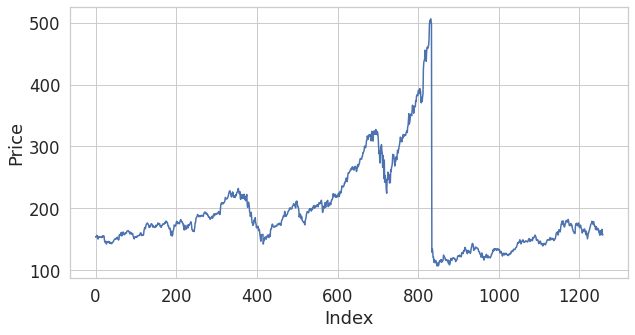

In [8]:
# Plot the closing price
fig = plt.figure(figsize = (10, 5))
plt.plot(df1)
plt.xlabel('Index')
plt.ylabel('Price')

## Data Preprocessing

LSTMs are sensitive to the scale of the data, so we apply MinMaxScaler

In [9]:
# scale price between 0, 1
scaler = MinMaxScaler(feature_range = (0, 1))
# Apply the scaler
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
print(type(df1), df1.shape)
print(df1)

<class 'numpy.ndarray'> (1259, 1)
[[0.11809643]
 [0.116268  ]
 [0.11799624]
 ...
 [0.14822793]
 [0.12505949]
 [0.12633688]]


In [10]:
# Splitting our data to train and test
train_size = int(len(df1) * 0.65)
test_size = len(df1) - train_size
print(train_size, test_size)

train_data, test_data= df1[0:train_size,:], df1[train_size:len(df1),:1]

818 441


In [11]:
train_data[:10]

array([[0.11809643],
       [0.116268  ],
       [0.11799624],
       [0.12338134],
       [0.12237946],
       [0.12180338],
       [0.10872887],
       [0.11446462],
       [0.11576706],
       [0.11809643]])

After Scaling and Splitting our data, we need to define a function that takes in two arguments, the dataset which is a NumPy array that we want to convert into a dataset, and the time_step  which is the number of previous time steps to use as input variables to predict the next time period.

In [12]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) -look_back -1):
        a = dataset[i: (i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    
    return np.array(dataX), np.array(dataY)

Let's  use this function to prepare the train and test datasets ready for modelling.

In [13]:
# reshape into X=t, t+1, t+2, Y=t+3
look_back = 3
train_X, train_Y = create_dataset(train_data, look_back)
test_X, test_Y = create_dataset(test_data, look_back)

To view the results, print the first 5 records of train X, and Y.

In [14]:
# View function results
train_X_5, train_Y_5 = train_X[:5], train_Y[:5]
print(train_X_5)
print('-' * 20)
print(train_Y_5)

[[0.11809643 0.116268   0.11799624]
 [0.116268   0.11799624 0.12338134]
 [0.11799624 0.12338134 0.12237946]
 [0.12338134 0.12237946 0.12180338]
 [0.12237946 0.12180338 0.10872887]]
--------------------
[0.12338134 0.12237946 0.12180338 0.10872887 0.11446462]


In [15]:
# View data shapes
print(train_X.shape, train_Y.shape)
print('-'* 20)
print(test_X.shape), print(test_Y.shape)

(814, 3) (814,)
--------------------
(437, 3)
(437,)


(None, None)

## Reshape Data for LSTM

The input to every LSTM layer must be 3D. The three dimensions of the input are:

*  Samples : One sequence is one sample. A batch is compromised of one or more samples.

*  Time Steps: One time step is one point of observation in the sample.

*  Features : One feature is one observation at a time step.

Reshape input to : [n_samples, n_timesteps, n_features]

In [16]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [17]:
# View data shapes
print('train_X shape: {}  test_Y shape: {}'.format(train_X.shape, test_X.shape))
print('train_Y shape: {}  test_Y shape: {}'.format(train_Y.shape, test_Y.shape))

train_X shape: (814, 1, 3)  test_Y shape: (437, 1, 3)
train_Y shape: (814,)  test_Y shape: (437,)


In [18]:
# Construct the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10800     
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 51,251
Trainable params: 51,251
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fit model on train data
history = model.fit(train_X, train_Y, validation_data = (test_X, test_Y), epochs=60, batch_size=64, verbose=1)

Epoch 1/60
13/13 [==============================] - 19s 271ms/step - loss: 0.0659 - val_loss: 0.0192
Epoch 2/60
13/13 [==============================] - 0s 18ms/step - loss: 0.0218 - val_loss: 0.0239
Epoch 3/60
13/13 [==============================] - 0s 15ms/step - loss: 0.0097 - val_loss: 0.0182
Epoch 4/60
13/13 [==============================] - 0s 15ms/step - loss: 0.0057 - val_loss: 0.0105
Epoch 5/60
13/13 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 6/60
13/13 [==============================] - 0s 18ms/step - loss: 6.4304e-04 - val_loss: 0.0045
Epoch 7/60
13/13 [==============================] - 0s 16ms/step - loss: 5.0562e-04 - val_loss: 0.0054
Epoch 8/60
13/13 [==============================] - 0s 18ms/step - loss: 5.0537e-04 - val_loss: 0.0059
Epoch 9/60
13/13 [==============================] - 0s 21ms/step - loss: 5.0437e-04 - val_loss: 0.0041
Epoch 10/60
13/13 [==============================] - 0s 10ms/step - loss: 3.8249e-04 - val_

In [21]:
# Train data prediction
predict_train = model.predict(train_X)
# Transform training data to original form
predict_train = scaler.inverse_transform(predict_train)
train_Y_inverse = scaler.inverse_transform(train_Y.reshape(-1, 1))

score_train = 0
for i in range(train_Y_inverse.shape[0]):
    score_train += np.sqrt(mean_squared_error(train_Y_inverse[i], predict_train[i]))
# Average training score
score_train = score_train / train_Y_inverse.shape[0]

# Test data prediction
predict_test = model.predict(test_X)
predict_test = scaler.inverse_transform(predict_test)
# .reshape(-1, 1) to avoid scikit-learn throwing error : Expected 2D array, got 1D
test_Y_inverse = scaler.inverse_transform(test_Y.reshape(-1, 1))

score_test = 0
for i in range(test_Y_inverse.shape[0]):
    score_test += np.sqrt(mean_squared_error(test_Y_inverse[i], predict_test[i]))
score_test = score_test / test_Y_inverse.shape[0]

print('Average Training Difference: {:.2f}'.format(score_train))
print('Average Testing Difference: {:.2f}'.format(score_test))
print('Train Accuracy for RMSE: {:.2f} '.format(100 - score_train))
print('Test Accuracy for RMSE: {:.2f} '.format(100 - score_test))

Average Training Difference: 3.59
Average Testing Difference: 5.63
Train Accuracy for RMSE: 96.41 
Test Accuracy for RMSE: 94.37 


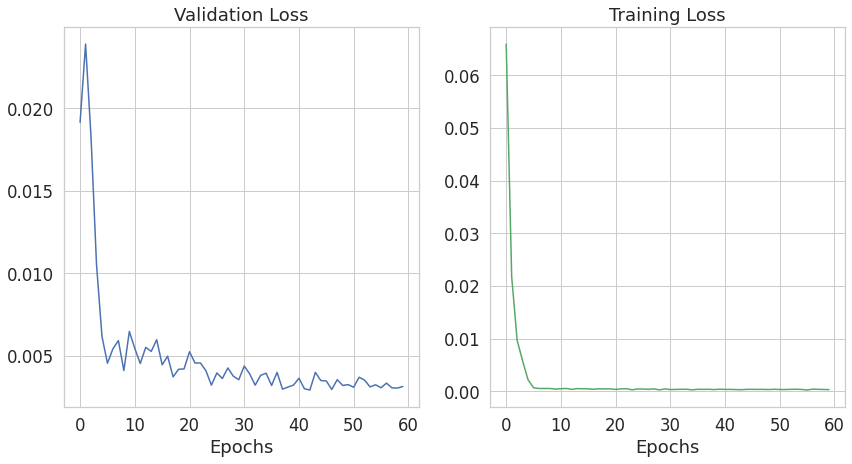

In [22]:
from IPython.core.pylabtools import figsize
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(np.array(history.history['val_loss']), color = 'b')
ax[1].plot(np.array(history.history['loss']), color = 'g')
# Set titles and Xlabels
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].title.set_text('Validation Loss')
ax[1].title.set_text('Training Loss')

## Plot Closing Prices: Actual Vs. Predicted

In [23]:
# Check shapes before plotting
print(predict_test.shape, test_Y_inverse.shape)

(437, 1) (437, 1)


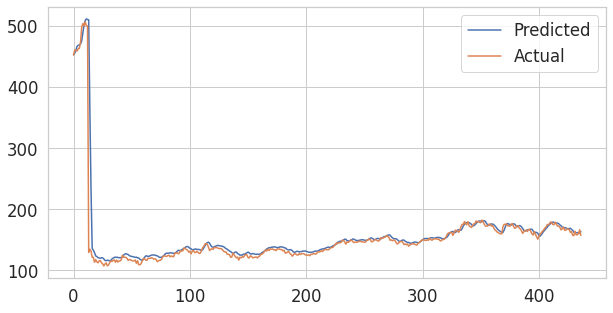

In [24]:
fig = plt.figure(figsize = (10, 5))
plt.plot(pd.DataFrame(predict_test), label='Predicted')
plt.plot(pd.DataFrame(test_Y_inverse), label='Actual')
plt.legend()
plt.show()